# Startup Success Prediction

### Objective
The objective of this notebook is to develop a machine learning model to predict the success of startups. Due to the nature of the data, success is defined as a startup being 'acquired'. This prediction model can be used by venture capital firms to evaluate potential investments.

### Overview of Steps Steps

1. **Data Cleaning and Preprocessing:**
   - Convert dates to datetime format.
   - Fill missing values.
   - Log transform of funding amounts.

2. **Feature Engineering:**
   - Create a binary target variable `successful` based on the `status` column.

3. **Sectoral Clustering:**
   - Use Latent Dirichlet Allocation (LDA) for clustering startups into sectors based on `category_code` and `country_code`.

4. **Label Encoding:**
   - Encode categorical features using LabelEncoder.

5. **Neural Network Model:**
   - Build and train a neural network to predict startup success.
   - Implement early stopping to prevent overfitting.
   - Evaluate the model using accuracy and mean absolute error.
   - Visualize training and validation accuracy and loss.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/MyDrive/Projects/StartupValuation/'

Mounted at /content/drive


## Data Prep

In [52]:
startup_df = pd.read_csv(root_path + 'dataset.csv')

In [48]:
print(startup_df.columns)

Index(['id', 'category_code', 'status', 'founded_at', 'logo_width',
       'logo_height', 'country_code', 'investment_rounds',
       'invested_companies', 'funding_rounds', 'funding_total_usd',
       'milestones', 'relationships', 'object_id', 'angel', 'crowdfunding',
       'other', 'post_ipo', 'private_equity', 'series_a', 'series_b',
       'series_c', 'venture', 'acquiring_object_id',
       'num_acquisizioni_effettuate', 'acquired_object_id',
       'have_been_acquired', 'funded_object_id_x', 'fin_org_financed',
       'funded_object_id_y', 'person_financed', 'funded_object_id',
       'startup_financed', 'parent_id', 'num_prodotti'],
      dtype='object')


In [53]:
# Data cleaning
startup_df['founded_at'] = pd.to_datetime(startup_df['founded_at'], errors='coerce')
startup_df.fillna(0, inplace=True)

# Feature engineering: log transform of funding amounts
startup_df['log_funding_total_usd'] = np.log1p(startup_df['funding_total_usd'])

In [54]:
# Define target variable (e.g., successful if 'status' is 'operating' or 'acquired')
startup_df['successful'] = startup_df['status'].apply(lambda x: 1 if x in ['acquired'] else 0)

# Check the counts of successful vs. not successful startups
success_counts = startup_df['successful'].value_counts()

print("Count of Successful vs. Not Successful Startups:")
print(success_counts)

Count of Successful vs. Not Successful Startups:
successful
0    187105
1      9393
Name: count, dtype: int64


## Label Encoding

In [55]:
# List of categorical features to encode
categorical_features = ['category_code', 'country_code', 'object_id', 'acquiring_object_id',
                        'acquired_object_id', 'funded_object_id_x', 'funded_object_id_y',
                        'funded_object_id', 'parent_id']

# Apply Label Encoding
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    startup_df[col] = le.fit_transform(startup_df[col].astype(str))  # Convert to string to handle missing values as unique labels
    label_encoders[col] = le

## Sectoral Clustering using LDA

In [32]:
# Use 'category_code' and 'country_code' for clustering
text_data = startup_df['category_code'].astype(str) + ' ' + startup_df['country_code'].astype(str)

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_vectorized = vectorizer.fit_transform(text_data)

# Apply LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)  # Adjust n_components based on your needs
lda.fit(text_vectorized)

# Add cluster labels to the DataFrame
startup_df['sector_cluster'] = lda.transform(text_vectorized).argmax(axis=1)

In [33]:
lda_components = lda.components_

# Get the feature names (words) from the CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Define a function to print the top words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Cluster {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

# Print the top words for each topic
print_top_words(lda, feature_names, 10)  # Adjust the number of top words as needed

Cluster 0:
31 34 19 148 24 116 22 152 95 83

Cluster 1:
71 12 35 21 33 40 135 69 94 67

Cluster 2:
29 163 126 80 173 79 84 82 164 107

Cluster 3:
38 32 50 77 53 102 169 162 57 86

Cluster 4:
42 163 17 11 86 51 79 130 150 128

Cluster 5:
163 38 36 28 22 25 14 106 23 15

Cluster 6:
23 15 16 43 41 20 78 140 171 160

Cluster 7:
10 26 54 37 27 115 81 45 156 64

Cluster 8:
55 39 70 93 36 124 166 28 25 101

Cluster 9:
13 73 18 36 134 108 30 49 137 146



## Model Development and Training

In [56]:
# Split data
X = startup_df.drop(columns=['id', 'founded_at', 'status','successful'])
y = startup_df['successful']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
# Define the neural network model
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [58]:
# Build and train the model
input_dim = X_train.shape[1]
model = build_model(input_dim)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
3930/3930 [==============================] - 14s 3ms/step - loss: 24654.7266 - accuracy: 0.9540 - val_loss: 50.6194 - val_accuracy: 0.9855
Epoch 2/20
3930/3930 [==============================] - 11s 3ms/step - loss: 738.2082 - accuracy: 0.9742 - val_loss: 0.0492 - val_accuracy: 0.9856
Epoch 3/20
3930/3930 [==============================] - 12s 3ms/step - loss: 154.8174 - accuracy: 0.9783 - val_loss: 0.0453 - val_accuracy: 0.9871
Epoch 4/20
3930/3930 [==============================] - 12s 3ms/step - loss: 72.4950 - accuracy: 0.9804 - val_loss: 0.0440 - val_accuracy: 0.9878
Epoch 5/20
3930/3930 [==============================] - 15s 4ms/step - loss: 18.7503 - accuracy: 0.9824 - val_loss: 0.0414 - val_accuracy: 0.9886
Epoch 6/20
3930/3930 [==============================] - 13s 3ms/step - loss: 2.3142 - accuracy: 0.9842 - val_loss: 0.0408 - val_accuracy: 0.9887
Epoch 7/20
3930/3930 [==============================] - 13s 3ms/step - loss: 1.1242 - accuracy: 0.9846 - val_loss: 0.04

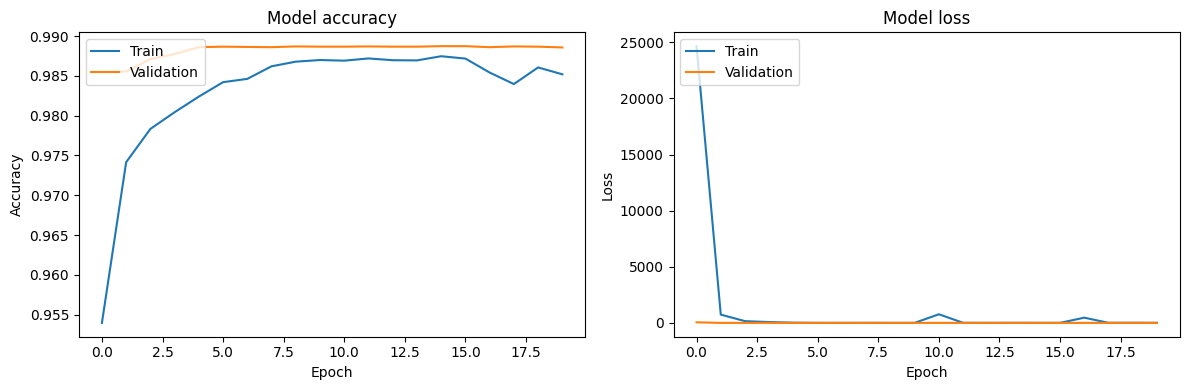

In [59]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [60]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy: {accuracy}')

1229/1229 [==============================] - 2s 2ms/step - loss: 0.0435 - accuracy: 0.9877
Model Accuracy: 0.9876844882965088


In [61]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

1229/1229 [==============================] - 3s 2ms/step


In [62]:
# Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred_classes)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.012315521628498728
